In [1]:
%matplotlib inline
%load_ext autoreload

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from os.path import join, exists
from os import mkdir
from glob import glob
import sys

sys.path.append(os.path.abspath('..'))

from scripts.train_simclr import *
from scripts.util import _parse_function, _sample_from_tfrecord

2024-08-30 01:47:58.643295: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-30 01:47:59.311521: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Set Up Dataset

In [8]:
# Build the training dataset from the BrCA TCGA Slides
ds = build_dataset(
    dataset_dir=FLAGS.dataset_dir,
    patch_size=FLAGS.input_s,
    shuffle=True,
    n_parallel=-1,
    max_ex=FLAGS.max_ex,
    return_len=False
)

# Define augmentation parameters with default values from FLAGS
# aug_params controls the intensity and probability of each augmentation:
# TODO
# Figure out why uncommenting these default definitions causes the images to become blurry

hp = {}
aug_params = {
    "blur_radius": hp.get("blur_radius", FLAGS.blur_radius),  # Radius for the blur effect, determines blur intensity
    "blur_p": hp.get("blur_p", FLAGS.blur_p),                # Probability of applying the blur effect
    "crop_frac": hp.get("crop_frac", FLAGS.crop_frac),       # Fraction of image to randomly crop and resize
    "rotate_limit": hp.get("rotate_limit", FLAGS.rotate_limit), # Maximum degrees for random rotation
    "h_flip_p": hp.get("h_flip_p", 0.5),                    # Probability of applying horizontal flip
    "v_flip_p": hp.get("v_flip_p", 0.5),                    # Probability of applying vertical flip
    "rotate_p": hp.get("rotate_p", 1.0),                    # Probability of applying random rotation of 90 degrees
    "elastic_alpha": hp.get("elastic_alpha", 50),           # Elastic transform alpha value for intensity
    "elastic_sigma": hp.get("elastic_sigma", 50),           # Elastic transform sigma value for smoothness
    "elastic_alpha_affine": hp.get("elastic_alpha_affine", 15), # Alpha affine for elastic transform affine transformations
    # "elastic_p": hp.get("elastic_p", 0.80),                 # Probability of applying elastic transformation
}
base_path = '/home/ubuntu/notebooks/cpc_hist/'
ds = prepare_dataset(
    ds,
    base_path,
    tile_size=FLAGS.input_s,
    batch_size=FLAGS.bs,
    aug_params=aug_params,
    num_parallel_calls=-1,
    preFetch=-1,
    train_size=-1,
)

2024-08-30 01:49:10,618 Using Dataset located at /home/ubuntu/notebooks/cpc_hist/resources/tfrecords
2024-08-30 01:49:10.656049: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]


## Show Examples

(256, 256, 256, 3)


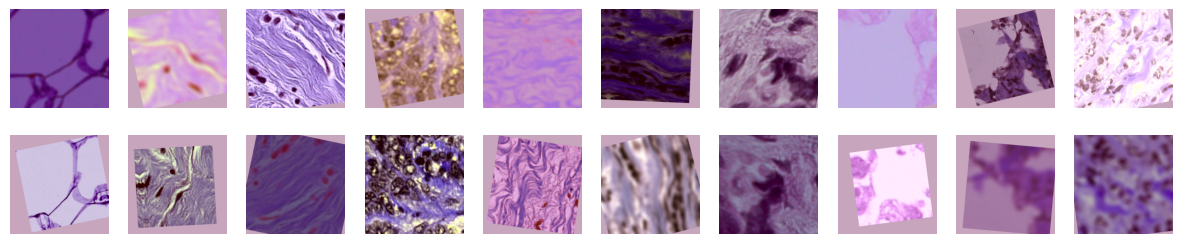

In [11]:
test_batch = next(iter(ds))
bs = test_batch.shape[0]
print(test_batch.shape)

N = 10
fig, axes = plt.subplots(2, N, figsize=(N * 1.5, 3))
for i, ax in enumerate(axes[0]):
    ax.imshow(test_batch[i].numpy())
    ax.axis('off')
for i, ax in enumerate(axes[1]):
    ax.imshow(test_batch[i + bs // 2].numpy())
    ax.axis('off')

plt.show()

# Setting up Model

In [12]:
hp = {}
model = build_model(hp)
model.build((FLAGS.bs, FLAGS.input_s, FLAGS.input_s, 3))

In [13]:
model.summary()

Model: "SimCLR_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet101 (Functional)      (None, 2048)              42658176  
                                                                 
 projection_head_1 (Project  multiple                  4467200   
 ionHead)                                                        
                                                                 
Total params: 47125376 (179.77 MB)
Trainable params: 47015680 (179.35 MB)
Non-trainable params: 109696 (428.50 KB)
_________________________________________________________________
